# Wrapping the call for the Bayesian optimization loop

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import os
import numpy as np
import netCDF4 as nc
import xarray as xr
import datatree as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sithom.plot import plot_defaults, label_subplots, lim
from tcpips.constants import DATA_PATH, FIGURE_PATH
from adforce.mesh import xr_loader

plot_defaults()

In [5]:
from slurmpy import Slurm

In [11]:
s = Slurm("nws13", 
          {"nodes": 1, 
           "account": "n01-SOWISE",
           "partition": "standard",
           "qos": "standard",
           "time": "1:0:0",
           "tasks-per-node": 128,
           "cpus-per-task": 1,
           "output": "test.out",
           "error": "test.out",
           "mail-type": "ALL",
           "mail-user": "sdat2@cam.ac.uk"}
)
jid = s.run(
"""
module load PrgEnv-gnu/8.3.3
module load cray-hdf5-parallel
module load cray-netcdf-hdf5parallel

work=/mnt/lustre/a2fs-work1/work/n01/n01/sithom
source $work/.bashrc

conda activate base

python -c "import numpy as np; print('numpy', np.__version__)"
python -c "import netCDF4 as nc; print('netCDF4', nc.__version__)"
python -c "import xarray as xr; print('xarray', xr.__version__)"
python -c "import cartopy; print('cartopy', cartopy.__version__)"
"""
)
jid

b'Submitted batch job 5751164'


5751164

In [6]:
s = Slurm(
    "angle-test",
    {
        "nodes": 1,
        "account": "n01-SOWISE",
        "partition": "standard",
        "qos": "standard",
        "time": "1:0:0",
        "tasks-per-node": 128,
        "cpus-per-task": 1,
        "output": "test.out",
        "error": "test.out",
        "mail-type": "ALL",
        "mail-user": "sdat2@cam.ac.uk",
    },
)

jid = s.run(
"""
module load PrgEnv-gnu/8.3.3
module load cray-hdf5-parallel
module load cray-netcdf-hdf5parallel

cd /mnt/lustre/a2fs-work1/work/n01/n01/sithom/adcirc-swan/angle_test/exp_000

work=/mnt/lustre/a2fs-work1/work/n01/n01/sithom
source $work/.bashrc

d1=/work/n01/n01/sithom/adcirc-swan/katrina1

echo "hook 1"
eval "$(conda shell.bash hook)"

# define variables
case_name=$SLURM_JOB_NAME # name for printing
np=128 # how many parallel tasks to define

export OMP_NUM_THREADS=1

# Propagate the cpus-per-task setting from script to srun commands
#    By default, Slurm does not propagate this setting from the sbatch
#    options to srun commands in the job script. If this is not done,
#    process/thread pinning may be incorrect leading to poor performance
export SRUN_CPUS_PER_TASK=$SLURM_CPUS_PER_TASK

#...Run the case
echo ""
echo "|---------------------------------------------|"
echo "    TEST CASE: $case_name"
echo ""
echo -n "    Prepping case..."
${d1}/adcprep --np $np --partmesh >  adcprep.log
${d1}/adcprep --np $np --prepall  >> adcprep.log
if [ $? == 0 ] ; then
    echo "done!"
else
    echo "ERROR!"
    exit 1
fi

echo -n "    Runnning case..."
srun --distribution=block:block --hint=nomultithread ${d1}/padcirc > padcirc_log.txt
exitstat=$?
echo "Finished"
echo "    ADCIRC Exit Code: $exitstat"
if [ "x$exitstat" != "x0" ] ; then
    echo "    ERROR: ADCIRC did not exit cleanly."
    exit 1
fi
echo ""

"""
)
jid

b'Submitted batch job 5754241'


5754241

In [26]:
import os, sys
import subprocess

args = f"sacct -j {jid} -o state"
job_states = [x.strip() for x in os.popen(args).read().strip().split("\n")]
is_finished = np.all([x == "COMPLETED" for x in job_states[2:]]) if len(job_states) > 2 else False

In [28]:
is_finished

True

In [30]:
import time
from sithom.time import timeit


@timeit
def run_and_wait(dir: str, jobname="run") -> int:
    s = Slurm(
        jobname,
        {
            "nodes": 1,
            "account": "n01-SOWISE",
            "partition": "standard",
            "qos": "standard",
            "time": "1:0:0",
            "tasks-per-node": 128,
            "cpus-per-task": 1,
            "output": os.path.join(dir, "test.out"),
            "error": os.path.join(dir, "test.out"),
            "mail-type": "ALL",
            "mail-user": "sdat2@cam.ac.uk",
        },
    )

    jid = s.run(
    f"""
module load PrgEnv-gnu/8.3.3
module load cray-hdf5-parallel
module load cray-netcdf-hdf5parallel

cd {dir}

work=/mnt/lustre/a2fs-work1/work/n01/n01/sithom
source $work/.bashrc

d1=/work/n01/n01/sithom/adcirc-swan/katrina1

echo "hook 1"
eval "$(conda shell.bash hook)"

# define variables
case_name=$SLURM_JOB_NAME # name for printing
np=128 # how many parallel tasks to define

export OMP_NUM_THREADS=1

# Propagate the cpus-per-task setting from script to srun commands
#    By default, Slurm does not propagate this setting from the sbatch
#    options to srun commands in the job script. If this is not done,
#    process/thread pinning may be incorrect leading to poor performance
export SRUN_CPUS_PER_TASK=$SLURM_CPUS_PER_TASK

#...Run the case
echo ""
echo "|---------------------------------------------|"
echo "    TEST CASE: $case_name"
echo ""
echo -n "    Prepping case..."
$d1/adcprep --np $np --partmesh >  adcprep.log
$d1/adcprep --np $np --prepall  >> adcprep.log
if [ $? == 0 ] ; then
    echo "done!"
else
    echo "ERROR!"
    exit 1
fi

echo -n "    Runnning case..."
srun --distribution=block:block --hint=nomultithread $d1/padcirc > padcirc_log.txt
exitstat=$?
echo "Finished"
echo "    ADCIRC Exit Code: $exitstat"
if [ "x$exitstat" != "x0" ] ; then
    echo "    ERROR: ADCIRC did not exit cleanly."
    exit 1
fi
echo ""

"""
    )
    def query_job(jid: int) -> bool:
        args = f"sacct -j {jid} -o state"
        job_states = [x.strip() for x in os.popen(args).read().strip().split("\n")]
        return np.all([x == "COMPLETED" for x in job_states[2:]]) if len(job_states) > 2 else False
    
    is_finished = query_job(jid)
    while not is_finished:
        is_finished = query_job(jid)
        time.sleep(10)

    print(f"Job {jid} finished")

    return jid


run_and_wait("/mnt/lustre/a2fs-work1/work/n01/n01/sithom/adcirc-swan/angle_test/exp_000")

b'Submitted batch job 5754702'


'run_and_wait'  07 min 14 s 



5754702

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [4]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import trieste
from sithom.time import timeit
from sithom.plot import plot_defaults
from trieste.acquisition import (
    # ExpectedImprovement,
    MinValueEntropySearch,
)
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.experimental.plotting.plotting import plot_bo_points, plot_function_2d
import matplotlib.pyplot as plt
plot_defaults()

2024-03-03 09:11:46.524931: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-03 09:11:49.865760: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 09:11:49.874733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 09:11:50.193432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 09:11:51.058500: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-03 09:11:51.112120: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
np.random.seed(1793)
tf.random.set_seed(1793)
print("trieste.__version__", trieste.__version__)
print("tf.__version__", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
tf.debugging.set_log_device_placement(True)

trieste.__version__ 3.0.0
tf.__version__ 2.15.0
Num GPUs Available:  0


In [6]:
TENSORBOARD_LOG_DIR = "logs/tensorboard/experiment1"
os.makedirs(TENSORBOARD_LOG_DIR, exist_ok=True)
files = os.listdir(TENSORBOARD_LOG_DIR)
for file in files:
    os.remove(os.path.join(TENSORBOARD_LOG_DIR, file))
summary_writer = tf.summary.create_file_writer(TENSORBOARD_LOG_DIR)
trieste.logging.set_tensorboard_writer(summary_writer)

print("summary_writer", summary_writer)

summary_writer <tensorflow.python.ops.summary_ops_v2._ResourceSummaryWriter object at 0x7fc3805283d0>


In [9]:
search_space = trieste.space.Box([0, 0], [1, 1])
observer = trieste.objectives.utils.mk_observer(
    trieste.objectives.ScaledBranin.objective
)
# observer = observation function (f(x))
initial_query_points = search_space.sample_sobol(5)
initial_data = observer(initial_query_points)

gpr = trieste.models.gpflow.build_gpr(initial_data, search_space)
model = trieste.models.gpflow.GaussianProcessRegression(gpr)


@timeit
def bo_optimize(
    num_steps: int = 15,
    acquisition_rule=EfficientGlobalOptimization(MinValueEntropySearch(search_space)),
) -> None:
    plot_defaults()
    bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
    result = bo.optimize(
        num_steps,
        initial_data,
        model,
        acquisition_rule,
        track_state=False,
    ).astuple()
    trieste.logging.set_summary_filter(lambda name: True)  # enable all summaries
    print("result", result)
    # print("history", history)
    real_res = result[0].unwrap()
    dataset = real_res.dataset

    query_points = dataset.query_points.numpy()
    observations = dataset.observations.numpy()

    _, ax = plot_function_2d(
        trieste.objectives.ScaledBranin.objective,
        search_space.lower,
        search_space.upper,
        contour=True,
        colorbar=True
    )
    plot_bo_points(
        query_points, ax[0, 0], 5, m_add="+",  # obs_values=observations
    )  # , arg_min_idx)
    plt.scatter(query_points[:, 0], query_points[:, 1], c=observations, cmap="viridis")
    
    ax[0, 0].set_xlabel(r"$x_1$")
    ax[0, 0].set_xlabel(r"$x_2$")
    plt.savefig("img/mves.png")

/work/n01/n01/sithom/miniconda3/lib/python3.10/site-packages/trieste/bayesian_optimizer.py:1117: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  query_new_df = pd.DataFrame(qp_preds, columns=columns).applymap(float)
/work/n01/n01/sithom/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/work/n01/n01/sithom/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/work/n01/n01/sithom/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 l

Optimization completed without errors
result (Ok(Record(datasets={'OBJECTIVE': Dataset(query_points=<tf.Tensor: shape=(20, 2), dtype=float64, numpy=
array([[0.40519714, 0.95332336],
       [0.28019714, 0.32832336],
       [0.78019714, 0.82832336],
       [0.53019714, 0.07832336],
       [0.03019714, 0.57832336],
       [0.3520741 , 0.13736968],
       [0.59128745, 0.19848659],
       [0.56681572, 0.12062491],
       [0.67719589, 0.05646019],
       [0.5600131 , 0.13774231],
       [0.49715319, 0.25840292],
       [0.5400783 , 0.16507701],
       [0.55238849, 0.        ],
       [0.52764347, 0.16629399],
       [0.54905926, 0.14314667],
       [0.54954839, 0.13757246],
       [0.5490507 , 0.1446357 ],
       [0.53625368, 0.16947221],
       [0.55405473, 0.12934182],
       [0.54920713, 0.1426739 ]])>, observations=<tf.Tensor: shape=(20, 1), dtype=float64, numpy=
array([[ 1.09833284],
       [-0.62012585],
       [ 1.75926458],
       [-1.01394877],
       [ 0.11405704],
       [-0.44887

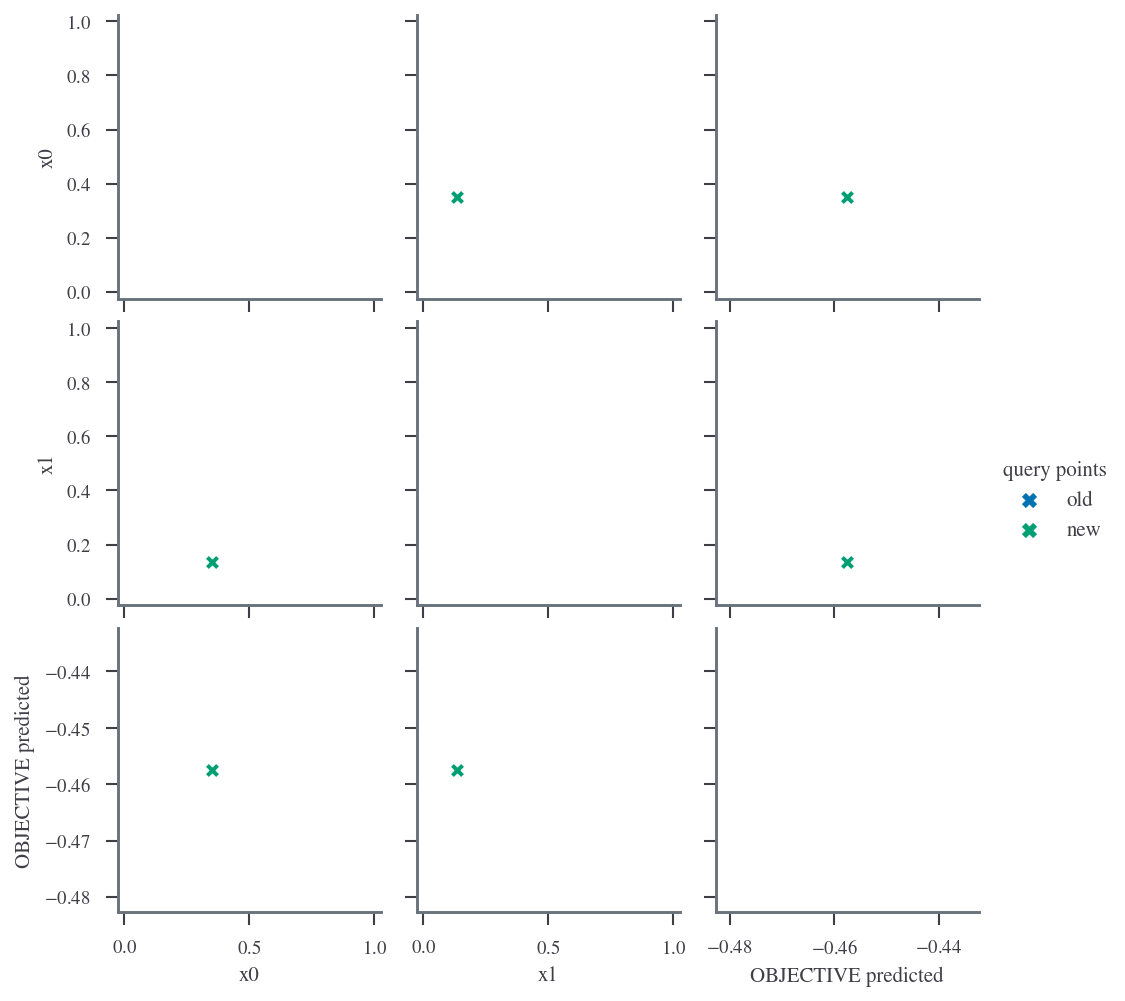

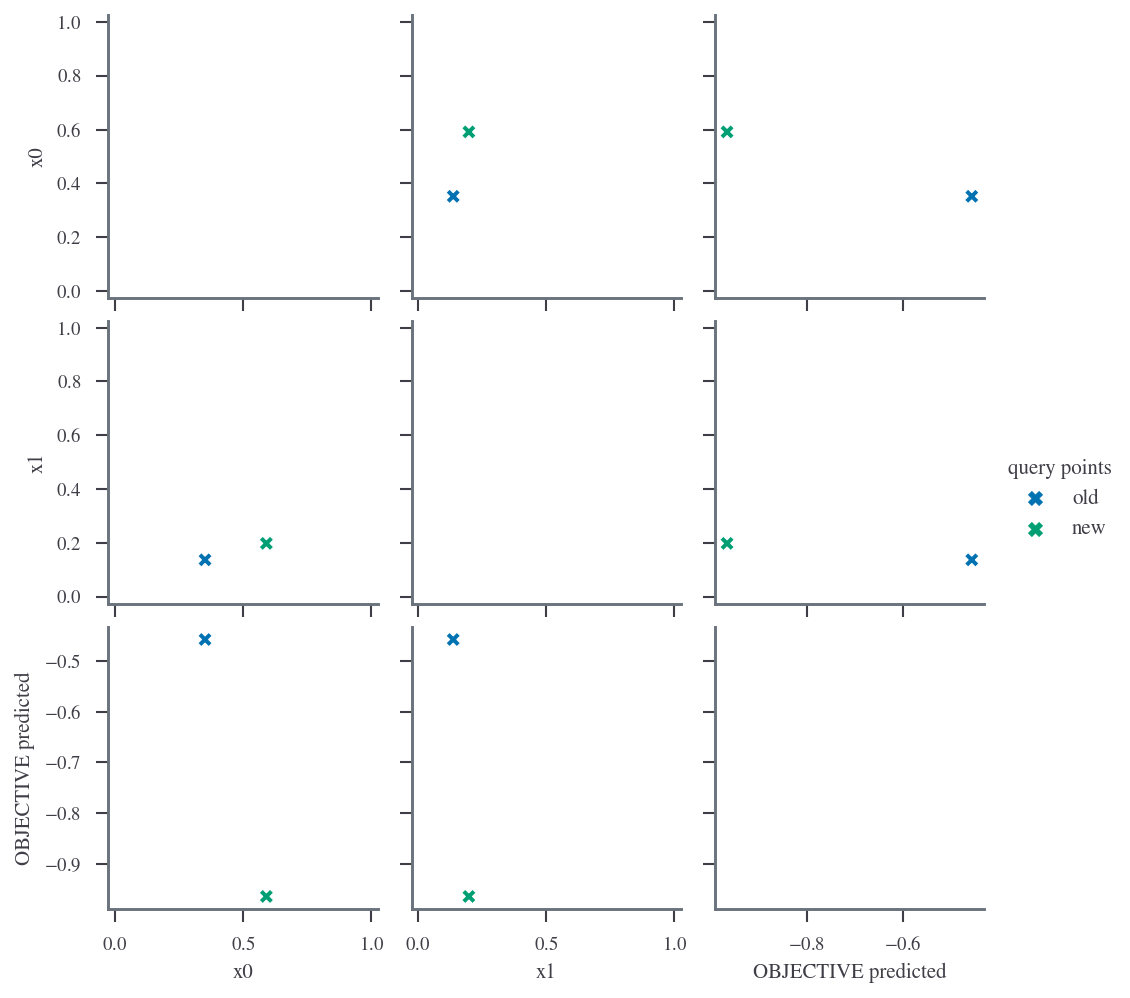

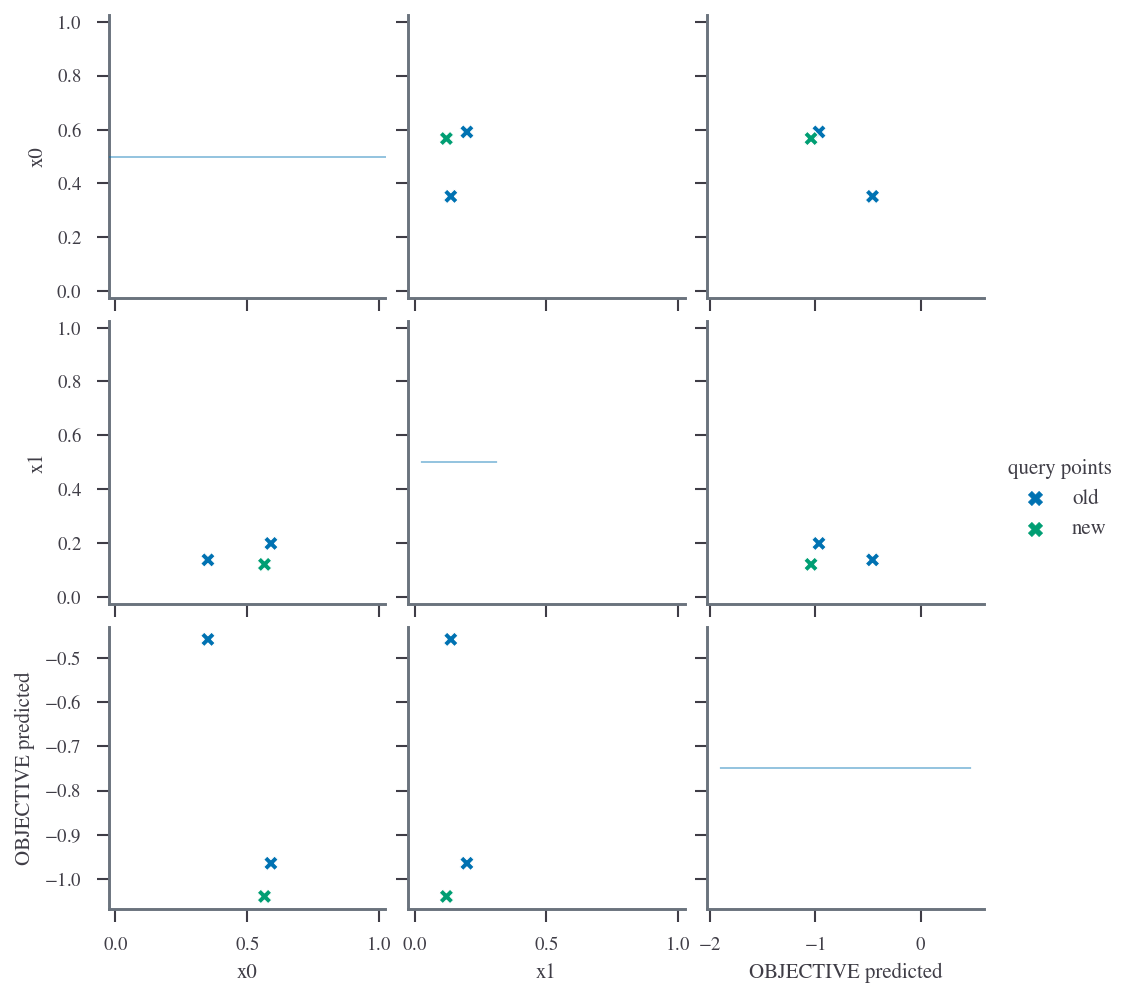

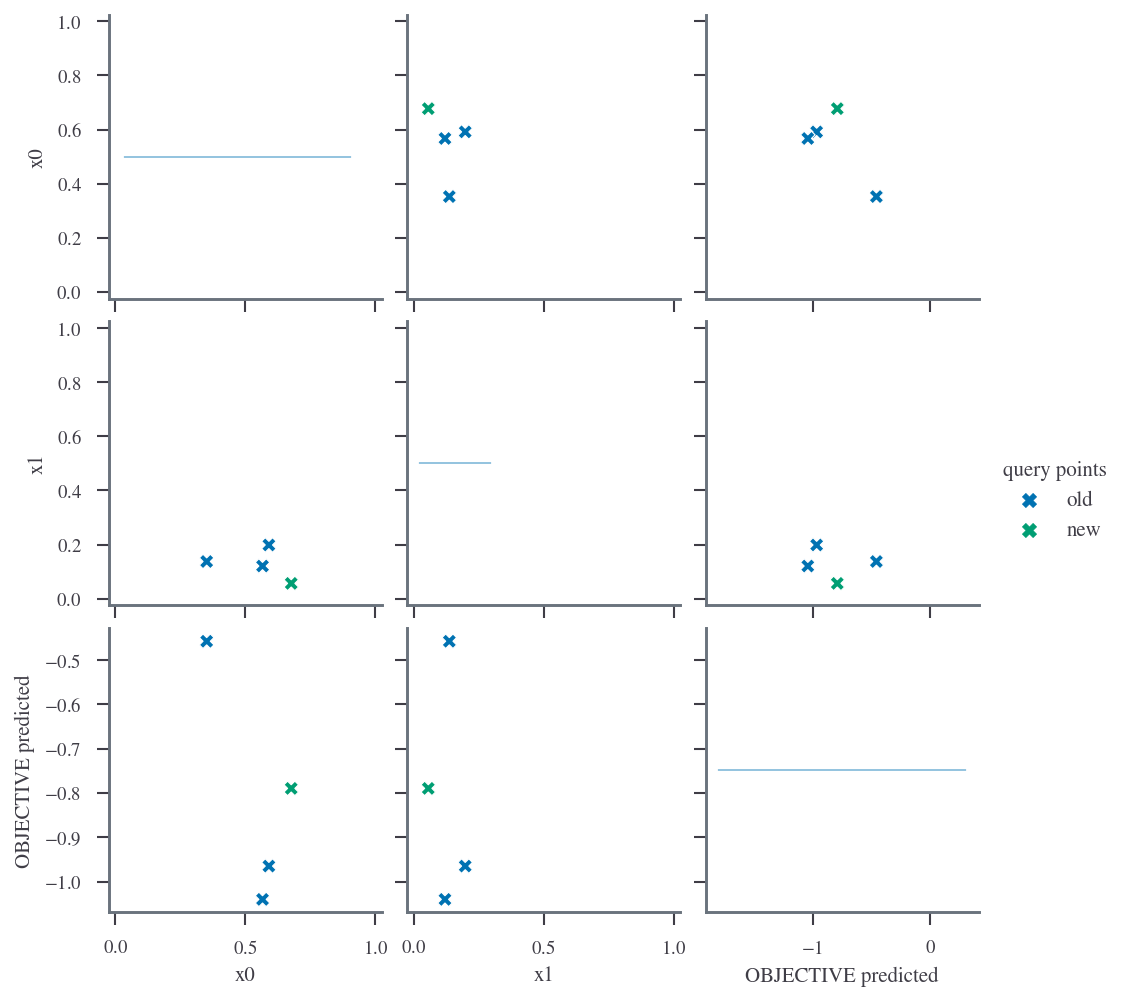

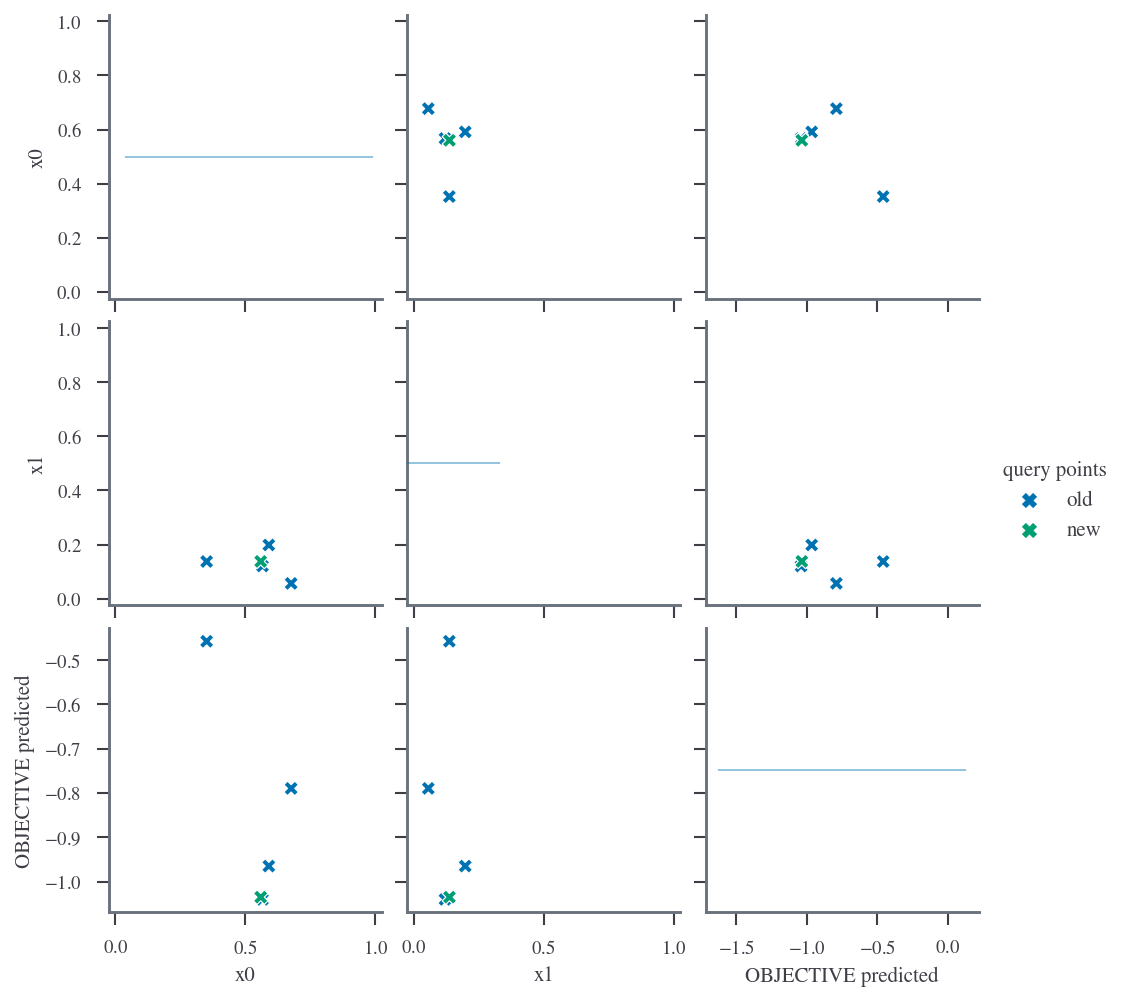

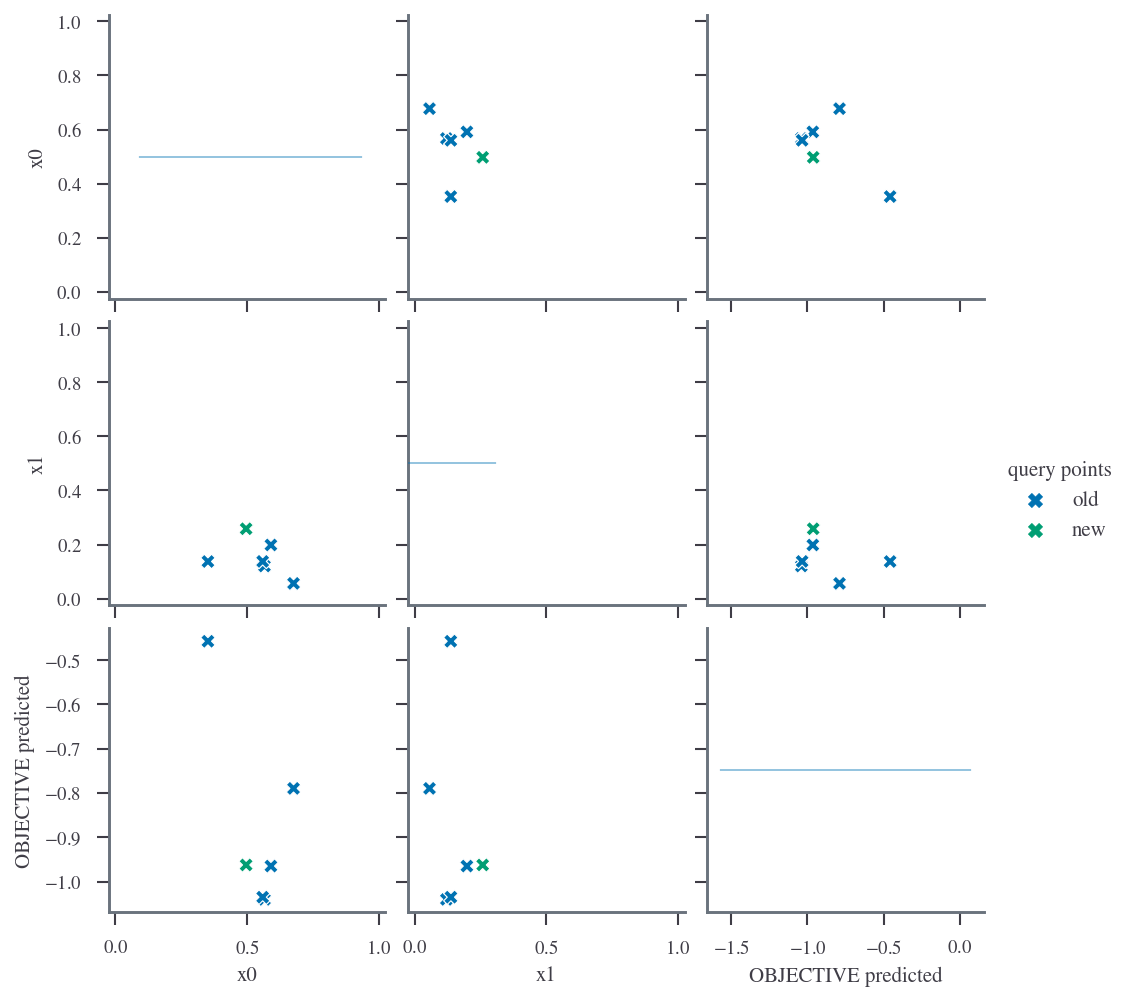

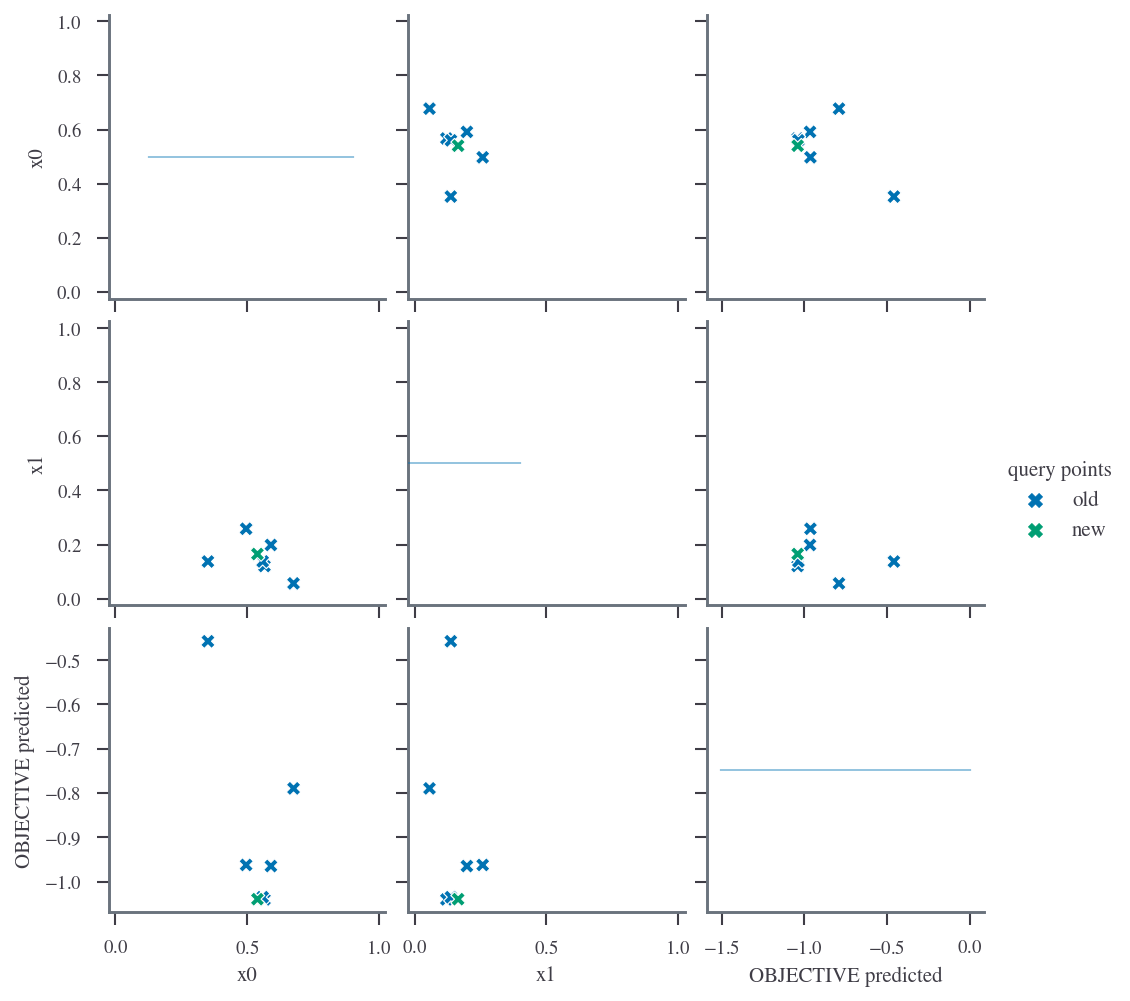

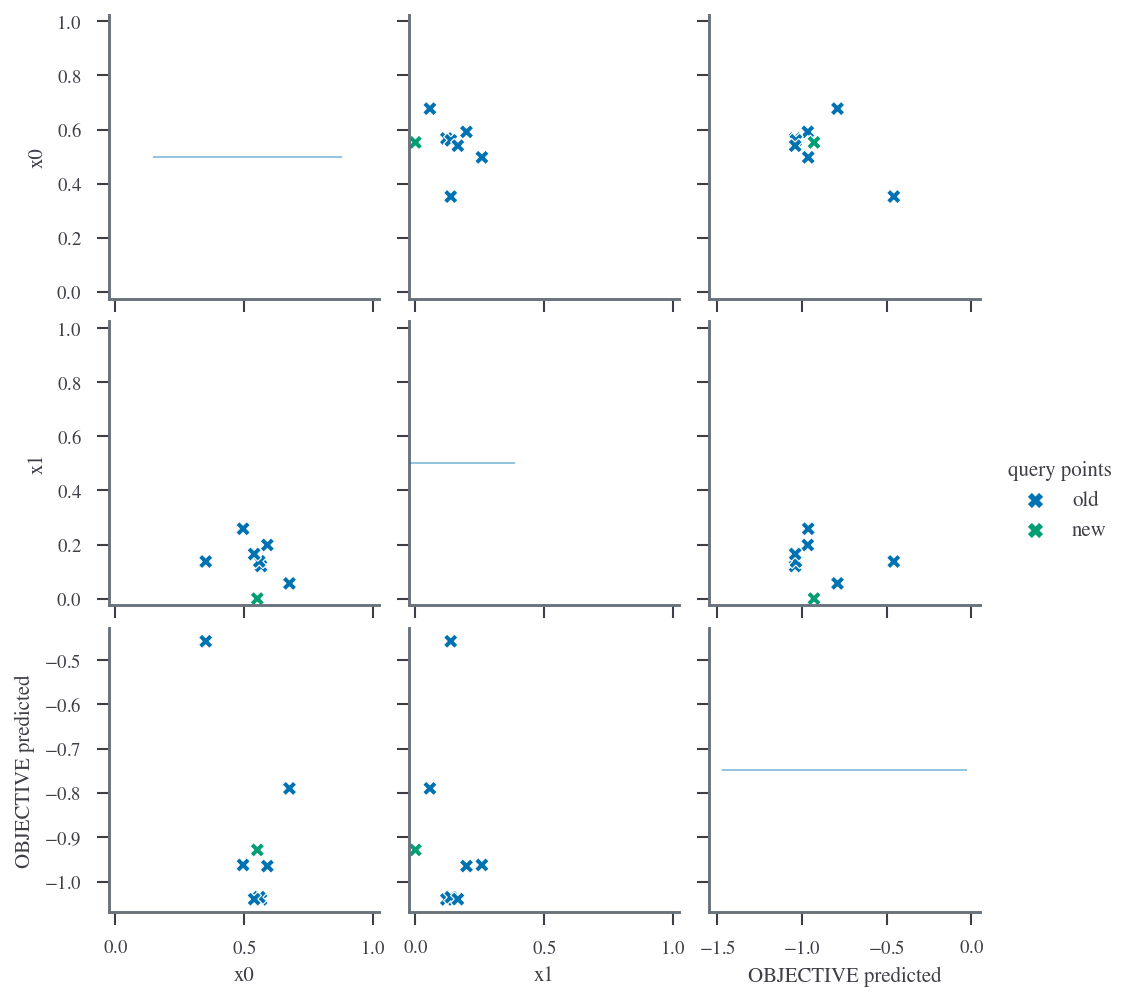

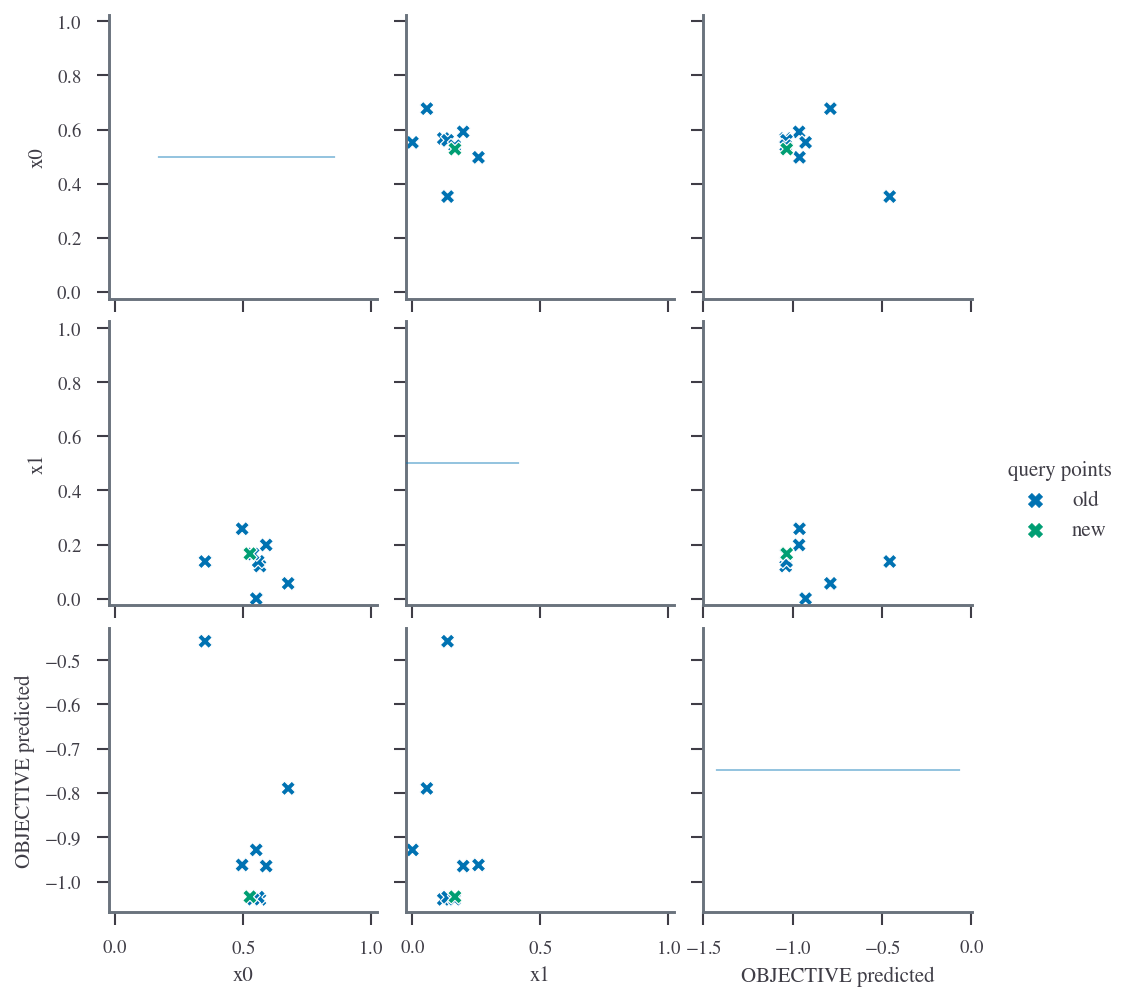

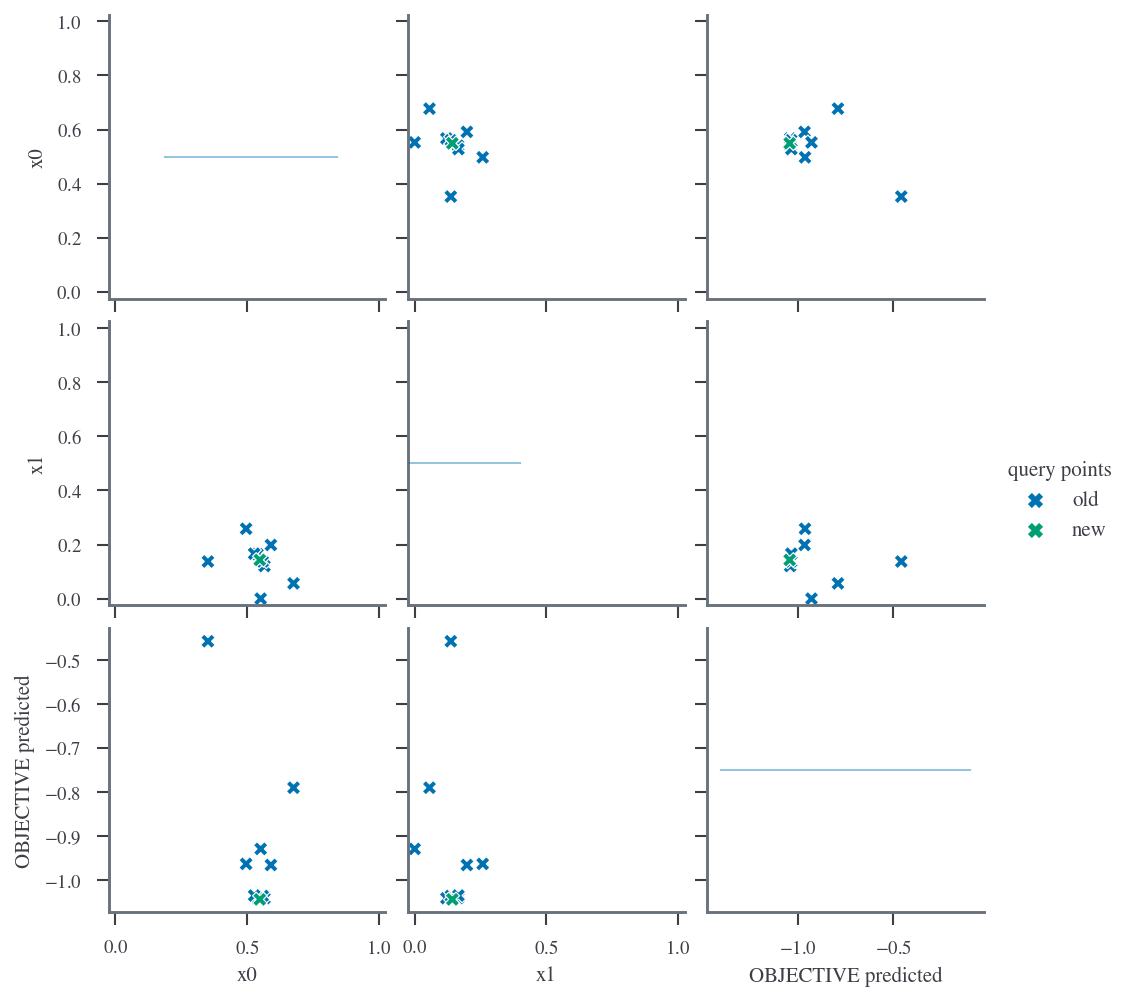

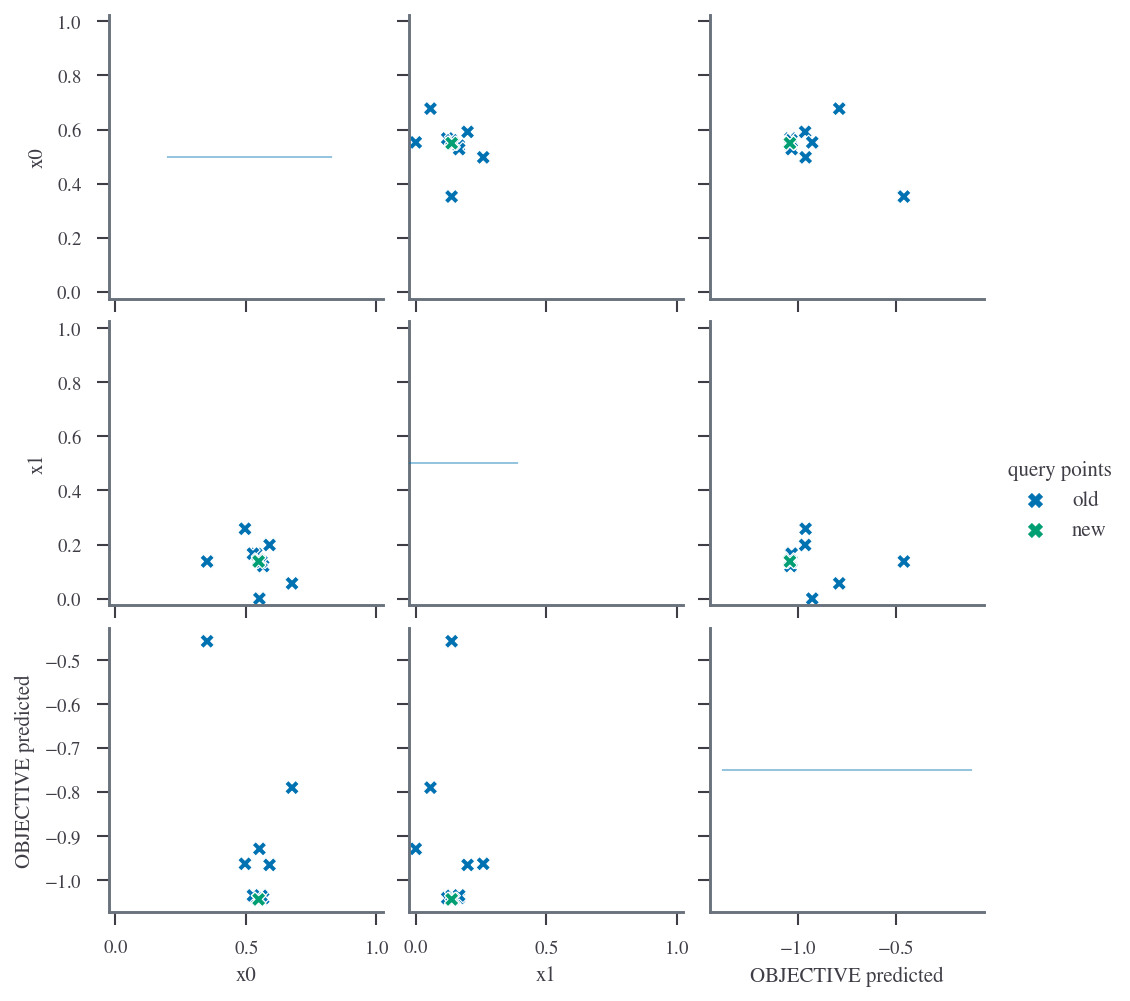

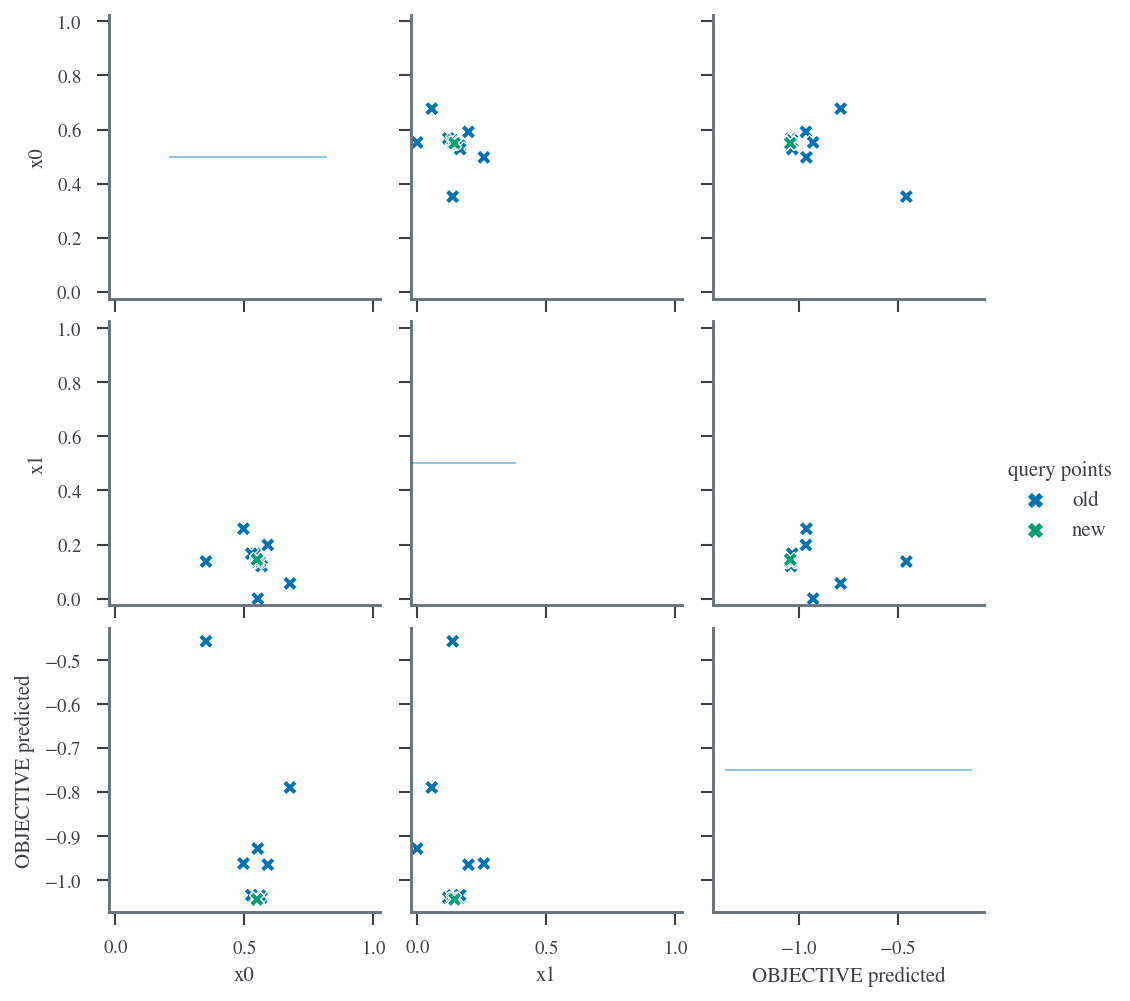

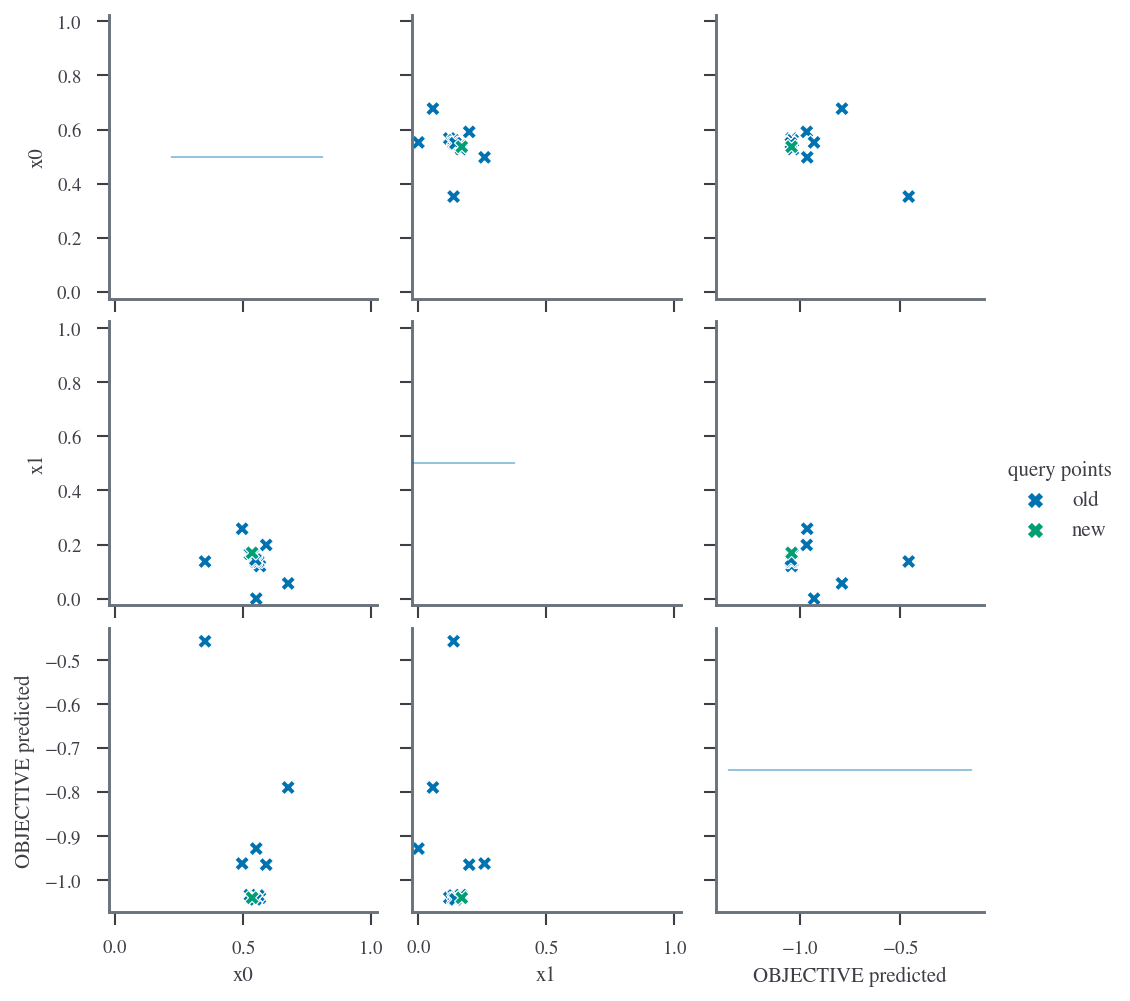

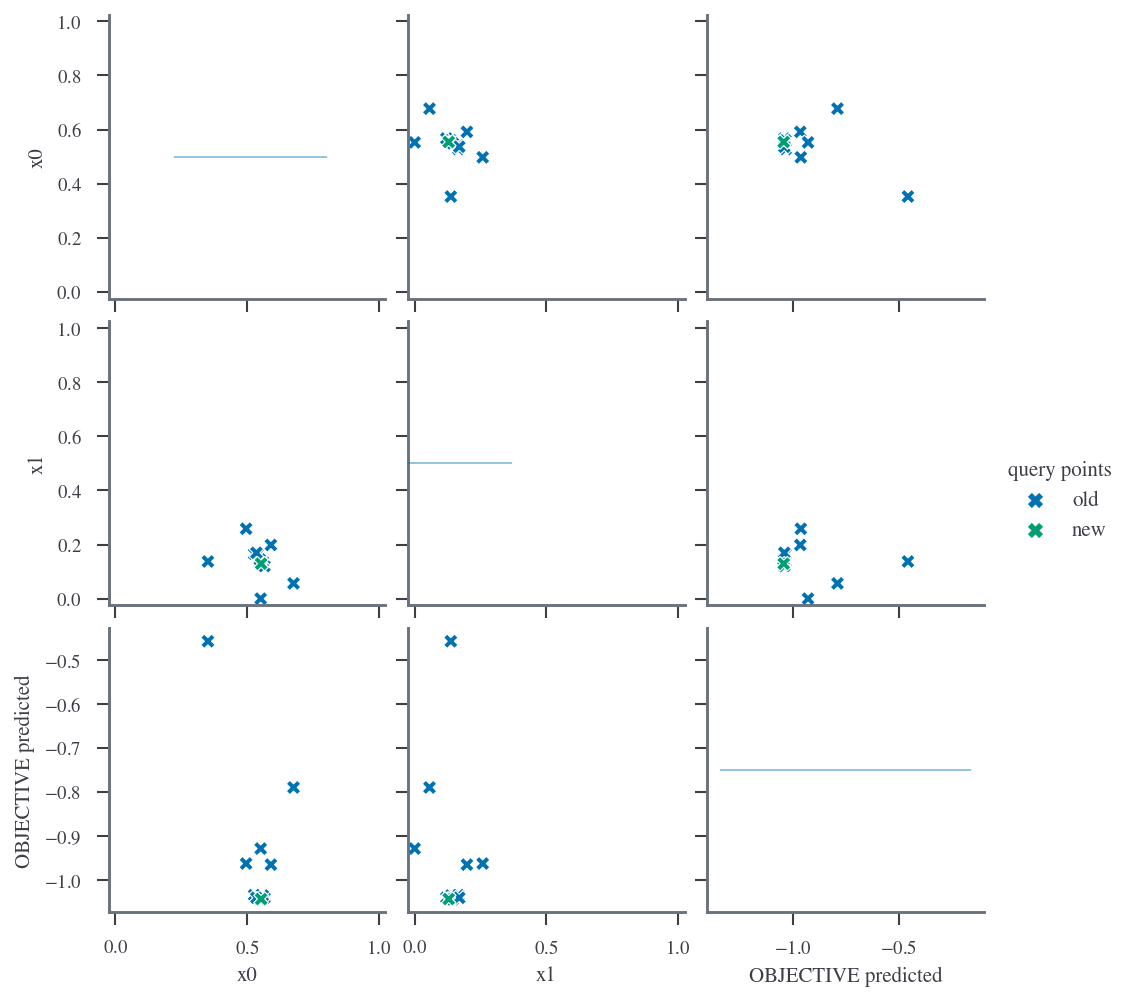

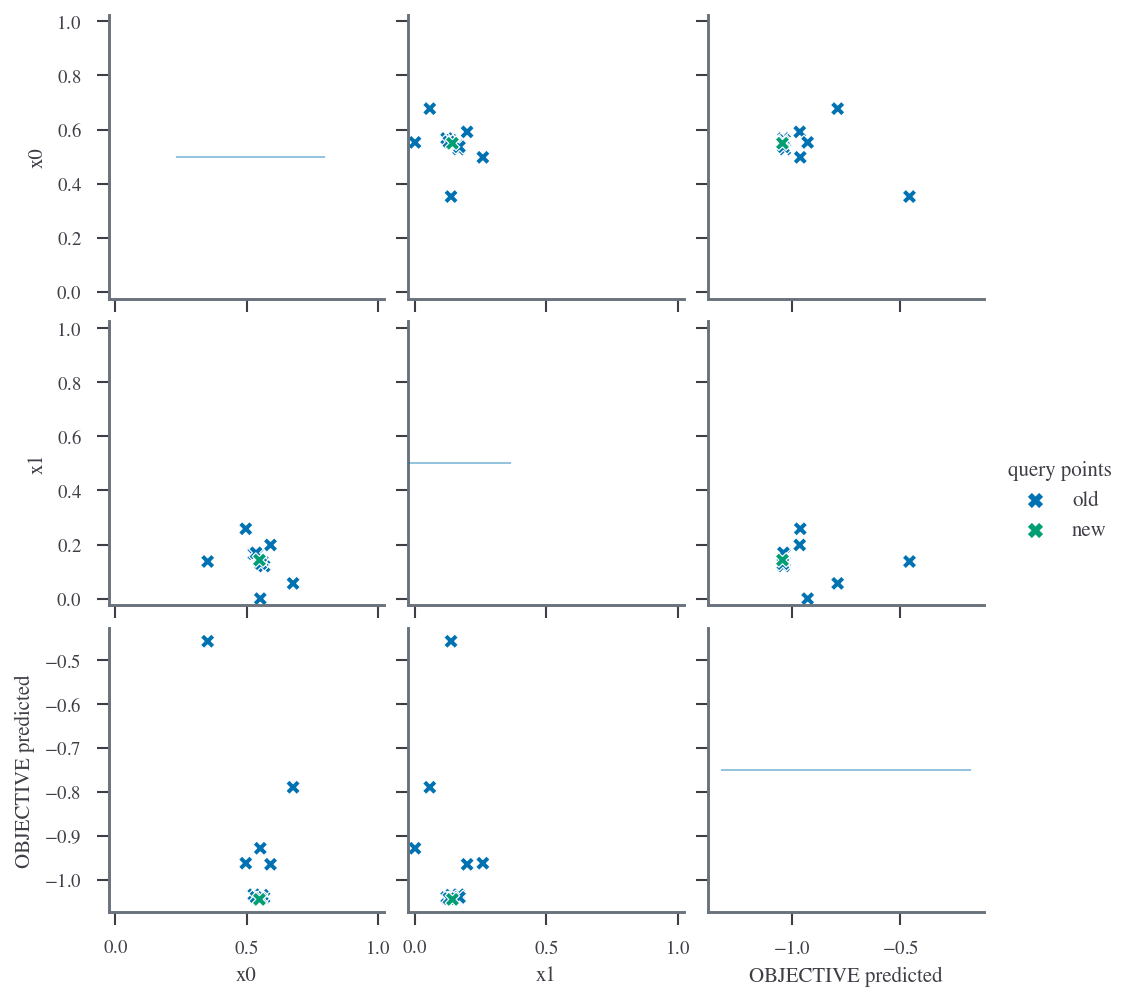

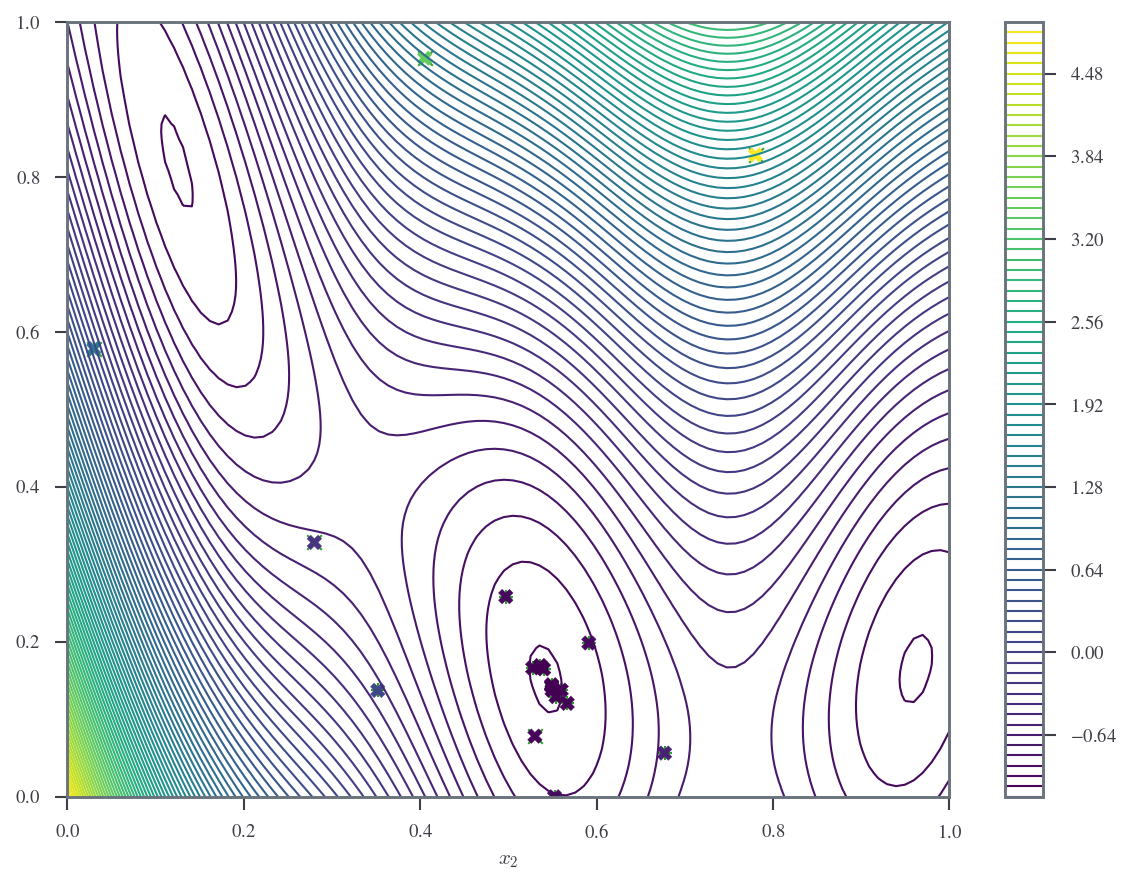

In [10]:
bo_optimize(15)